# Geographic analysis of patient flow - municipalities receiving more than 0.5% as poles

This notebook uses a geographic approach to **analyze the patient flow** through the municipalities in the Brazilian states. The first part of the analysis will be based on creating a **Voronoi diagram** from the centroids of municipalities defined as major healthcare poles. We will start with geographical distance but later refine it to road/highway-based distance. From this, we will obtain a Voronoi cell for each pole and observe whether patients are moving or not to the nearest pole to receive the health service. 

By analyzing the evolution of these data over the past 20 years for each Brazilian state, we can **evaluate the effectiveness of the regionalization process** in different regions of the country and in different moments of our recent history.

## Task Organization

1. Define the Voronoi seeds and plot the Voronoi diagram over the state map   

2. Create the origin-destination matrix and calculate the entropy   

3. Analyze the same matrix to other years  

4. Analyze the same visualization and matrix to other Brazilian states  
  
---

### Part 1: Define the Voronoi seeds and plot the Voronoi diagram over the state map

- Found the centroid point for each municipality pole***** for the chosen Brazilian state (Bahia - BA)
- Plot the Voronoi diagram using these points as seeds
- Add the geographic map of the state as a layer 

  
#### * for now, we define a _Municipality Pole_ as a municipality receiving more than 0.5% of the total hospitalizations

#### Import and save the IBGE municipalities data

source (using 2019*): https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais

*buscar a malha territorial para os outros anos (2000, 2005, 2010, 2015-2019), quando necessario

In [2]:
import geopandas as gpd
import numpy as np

municipalities_data = gpd.read_file("../data/BA_Municipios_2019.dbf", encoding = "utf-8")
codes = np.array([item[:-1] for item in np.array(municipalities_data.CD_MUN)]).astype('int') # trim last char
centroids = municipalities_data.geometry.centroid

# municipalities [CODE, NAME, SHAPE, CENTROID_POINT]
municipalities = np.c_[codes, municipalities_data.NM_MUN, municipalities_data.geometry, centroids]

**Obs.:** Pandas is faster then Numpy only when there are about 500k rows or more. For now, we are using numpy arrays to save 'municipalities' data and 'flow' data. Remember to **rethink this when using the flow data of the entire country**.

#### Import the patient flow data and restrict the Voronoi seeds to the municipalities pole

In [3]:
import pandas as pd 

# read patient flow data for each Brazilian state and year (from 1998 to 2017)
data = pd.read_csv("../data/sih_mun_pairs_1998_2017.csv", usecols=['year', 'UF', 'CODMUN_ocor', 'CODMUN_res', 'nhospadm_total']) 

# filter data when there are any hospitalization (removing empty flows)
flow_data = data.dropna()

# filter the dataset to Bahia
is_BA = flow_data['UF']=='BA'
BA_flow_data = flow_data[is_BA]

# filter the dataset only to year 1998
is_BA_1998 = BA_flow_data['year']==2017
BA_flow_data_1998 = BA_flow_data[is_BA_1998]
BA_flow_data_1998

year  UF  CODMUN_ocor  CODMUN_res  nhospadm_total
2233496  2017  BA       290020      290010             1.0
2233529  2017  BA       290280      290010             1.0
2233913  2017  BA       290020      290020           342.0
2233930  2017  BA       290160      290020             7.0
2234014  2017  BA       290840      290020             1.0
...       ...  ..          ...         ...             ...
2406954  2017  BA       293290      293350           212.0
2406965  2017  BA       293350      293350          1391.0
2407356  2017  BA       293150      293360             1.0
2407381  2017  BA       293345      293360             1.0
2407383  2017  BA       293360      293360          3155.0

[2039 rows x 5 columns]

In [4]:
# get the number of hospitalizations each municipality had

array_flows = np.array(BA_flow_data_1998).T[[2, 3, 4]].T.astype('int')
array_flows = array_flows[array_flows[:,0].argsort()]
hosp_per_mun = np.zeros((np.unique(array_flows.T[0]).shape[0], 2), dtype='int')
curr_code = array_flows[0][0]
i = 0

for flow in array_flows:
    if flow[0] != curr_code:
        curr_code = flow[0]
        i += 1
    hosp_per_mun[i][0] = flow[0]
    hosp_per_mun[i][1] += flow[2]

In [5]:
def get_gt_X_percent_mun(hosp_per_mun, X, total):
    X *= 0.01 # X% of total flows
    part_flows = total*X

    gt_X = hosp_per_mun.T[1] > part_flows

    gt_X_mun = hosp_per_mun.T[0][gt_X]
    
    return gt_X_mun, part_flows

In [6]:
# get all municipalities recieving more than X% of the total flows (the poles)

percent = 0.5

total_flows = BA_flow_data_1998['nhospadm_total'].sum()
pole_codes, part_flows = get_gt_X_percent_mun(hosp_per_mun, percent, total_flows)

print("Total hospitalizations sum:", total_flows)
print("%.1f percent of total hospitalizations: %.2f"%(percent, part_flows))
print("%d/%d municipalities is a pole" %(pole_codes.shape[0], municipalities.shape[0]))

Total hospitalizations sum: 702763.0
0.5 percent of total hospitalizations: 3513.82
29/417 municipalities is a pole


In [7]:
# filter municipalities to poles
is_pole = np.isin(municipalities.T[0], pole_codes)
poles = municipalities[is_pole]

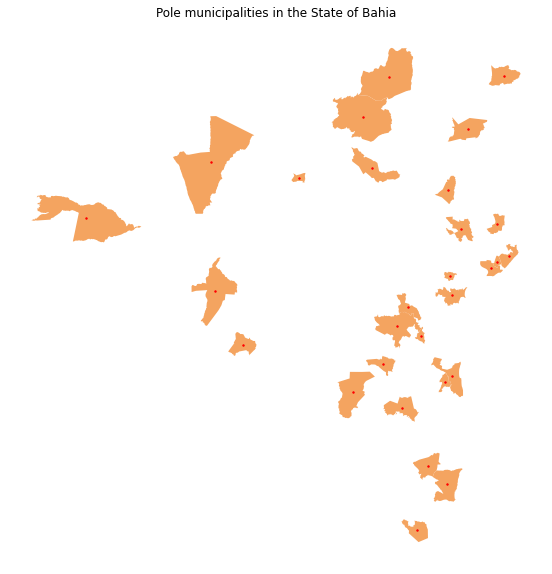

In [8]:
import matplotlib.pyplot as plt

# plot map and centroids
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(poles.T[2]).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(poles.T[3]).plot(ax=ax, markersize=2, color="red")
ax.axis("off")
plt.title("Pole municipalities in the State of Bahia")
plt.show()

In [19]:
state_boundary.type

'MultiPolygon'

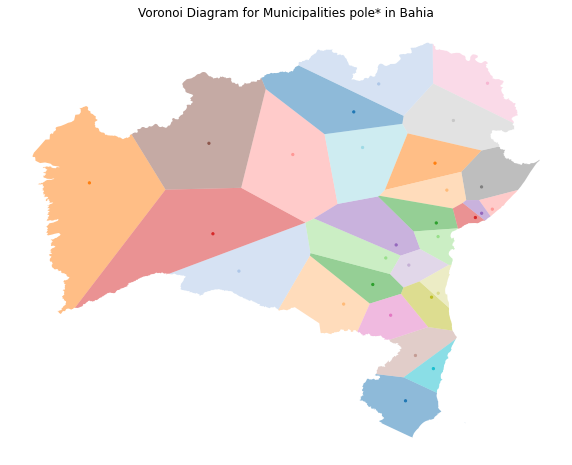

In [9]:
from shapely.ops import cascaded_union
from geovoronoi import points_to_coords, voronoi_regions_from_coords
from geovoronoi.plotting import plot_voronoi_polys_with_points_in_area


state_boundary = cascaded_union(municipalities.T[2])
poles_coords = points_to_coords(poles.T[3])

# calculate Voronoi cells
voronoi_cells, seeds, cell_to_seed_assignments = voronoi_regions_from_coords(poles_coords, state_boundary)

# plot Voronoi cells 
fig, ax = plt.subplots(figsize=(10, 8))
plot_voronoi_polys_with_points_in_area(ax, state_boundary, voronoi_cells, seeds, 
                                       cell_to_seed_assignments, area_edgecolor='white')

ax.set_title('Voronoi Diagram for Municipalities pole* in Bahia')
ax.axis("off")
plt.show()

---
### Part 2: Create the origin-destination matrix and calculate the entropy 

- Create the OD matrix in a specific year, where each line _i_ contains the number of patients residing in a Voronoi cell _i_ going to each Voronoi cell _j_
- Calculate the entropy of each line 

In [20]:
from geovoronoi import assign_points_to_voronoi_polygons

# create relation between the Voronoi cell and the municipalities it contains
#  where the ith position in the array contain the municipalities indexes that the ith cell contains
assignments = assign_points_to_voronoi_polygons(municipalities.T[3], voronoi_cells)

municipalities_pole = np.zeros(municipalities.shape[0])
pole_shapes = np.empty(municipalities.shape[0]).astype('object')

pole_indexes = np.array(cell_to_seed_assignments).T[0]

for cell_i in range(len(voronoi_cells)):
    pole_code = poles.T[0][pole_indexes[cell_i]]
    
    for seed_i in range(len(assignments[cell_i])):
        municipalities_pole[assignments[cell_i][seed_i]] = pole_code
        pole_shapes[assignments[cell_i][seed_i]] = voronoi_cells[cell_i]
        
municipalities_pole = municipalities_pole.astype('int')

# municipalities [CODE, NAME, SHAPE, CENTROID_POINT, POLE_CODE, POLE_SHAPE]
municipalities = np.c_[municipalities, municipalities_pole, pole_shapes]

In [46]:
# filter municipalities to poles
is_pole = np.isin(municipalities.T[0], pole_codes)
poles = municipalities[is_pole]

In [47]:
def getPoleIndex(code):
    row, col = np.where(municipalities == code)
    row, col = np.where(poles == municipalities[row[np.where(col == 0)[0][0]]][4])
    return row[np.where(col == 0)[0][0]]

In [48]:
# get municipalities flows
flows = np.array(BA_flow_data_1998).T[[2, 3, 4]].T.astype('int') 

pole_flows = np.empty(flows.shape).astype('int')

# get pole flows
for i in range(flows.shape[0]):
    pole_flows[i][0] = getPoleIndex(flows[i][1])
    pole_flows[i][1] = getPoleIndex(flows[i][0])
    pole_flows[i][2] = flows[i][2]

pole_flows

array([[  10,   19,    1],
       [  10,   18,    1],
       [  19,   19,  342],
       ...,
       [   1,    6,    1],
       [   1,    1,    1],
       [   1,    1, 3155]])

In [49]:
# create a origin-destination matrix
OD_matrix = np.zeros((poles.shape[0], poles.shape[0])).astype('int')
for flow in pole_flows:
    OD_matrix[flow[0]][flow[1]] += flow[2]
OD_matrix

array([[ 16185,      0,      1,      0,    225,      0,     39,    289,
             0,    264,      0,      0,      0,      1,      2,      0,
             0,      1,      0,      0,      0,      0,      0,   1464,
             2,     51,      0,      0,      0],
       [     0,  15571,    532,      4,      0,    133,      2,      0,
             0,     13,      2,      0,      0,      0,      0,      0,
             1,      1,      0,      1,      0,      0,      0,    122,
             1,      0,      1,      0,      2],
       [     1,     43,  18615,     37,      0,      0,      0,      0,
             0,     17,      1,      0,      0,      9,      0,      0,
             1,      8,      0,      0,      0,      0,      0,     65,
             0,      1,      0,      0,      0],
       [     1,      5,    516,  29354,      0,      0,      2,      0,
             0,      9,    647,      0,      0,     21,      4,      9,
            17,      0,      2,      0,      1,      0,      

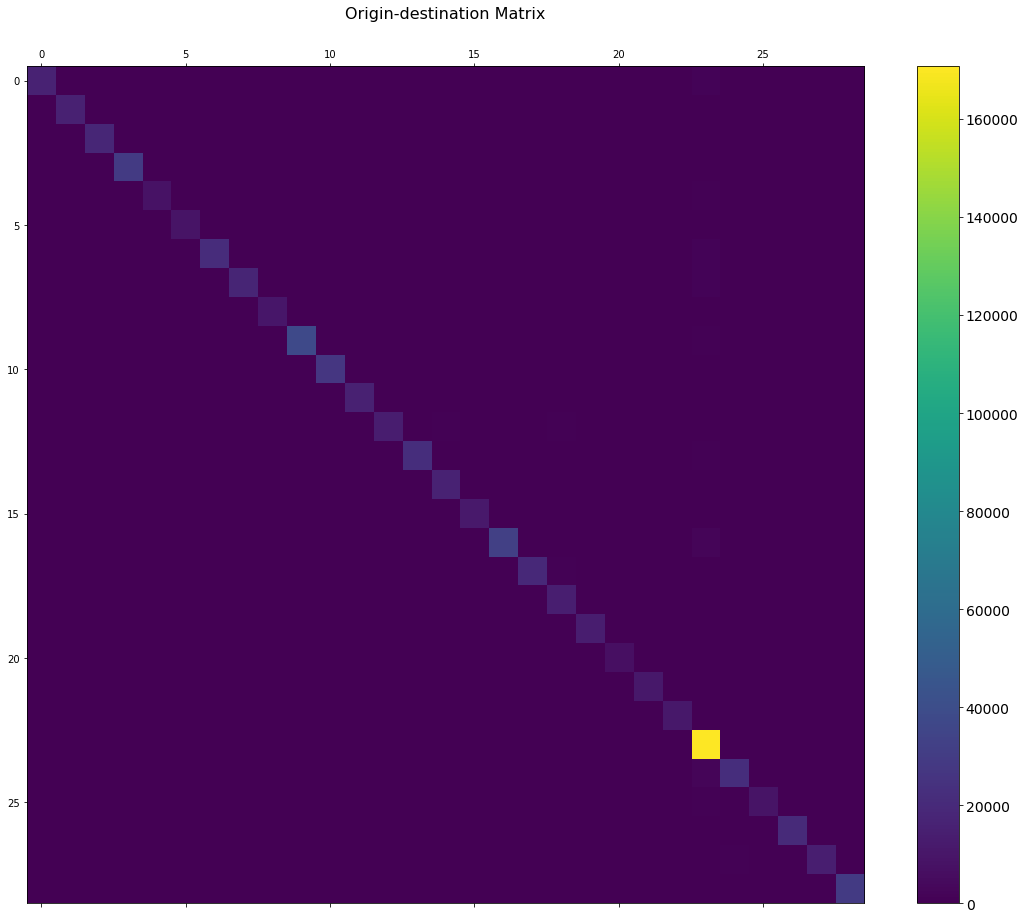

In [50]:
f = plt.figure(figsize=(19, 15))
plt.matshow(OD_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-destination Matrix', fontsize=16)
plt.show()

In [51]:
# here, each line is divided by its largest flow number
new_OD_matrix = OD_matrix.astype('float')

for i in range(OD_matrix.shape[0]):
    new_OD_matrix[i] = new_OD_matrix[i]/float(new_OD_matrix[i].max())

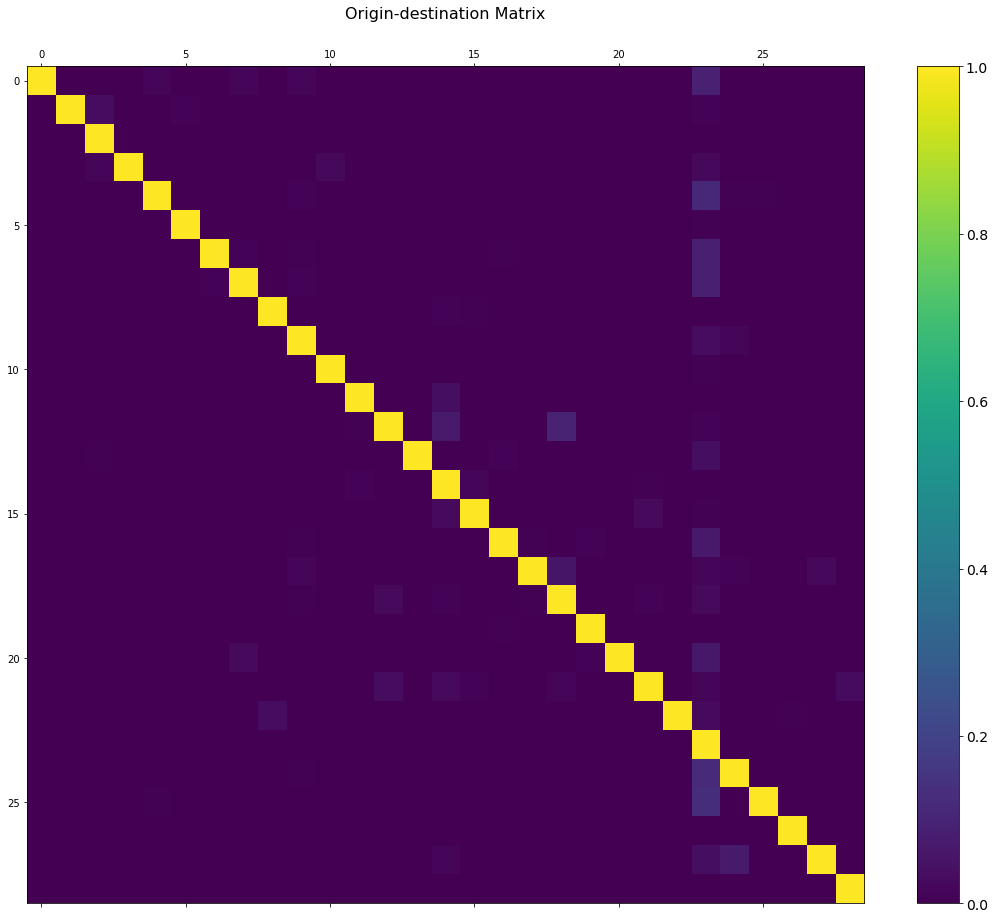

In [52]:
f = plt.figure(figsize=(19, 15))
plt.matshow(new_OD_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-destination Matrix', fontsize=16)
plt.show()

In [54]:
# poles[11]

array([291360, 'Ilhéus',
       <shapely.geometry.point.Point object at 0x7f2e3185ee20>, 291360,
      dtype=object)

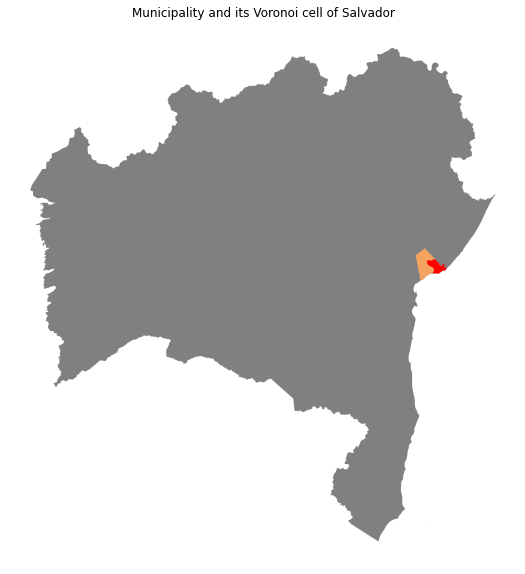

In [69]:
# plot a pole municipality and its Voronoi cell
mun = 23
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(state_boundary).plot(ax=ax, color="gray")
gpd.GeoSeries(poles[mun][-1]).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(poles[mun][2]).plot(ax=ax, color="red")
ax.axis("off")
plt.title("Municipality and its Voronoi cell of " + poles[mun][1])
plt.show()

#### Calculate the entropy of each line

In [68]:
from scipy.stats import entropy

poles_entropy = np.c_[poles.T[1], entropy(new_OD_matrix, axis=1)]
_, unique = np.unique(municipalities.T[4], return_index=True)
voronoi_shapes = municipalities.T[5][unique]

geo_voronoi = gpd.GeoDataFrame({'geometry': voronoi_shapes, 'entropy': poles_entropy.T[1]})

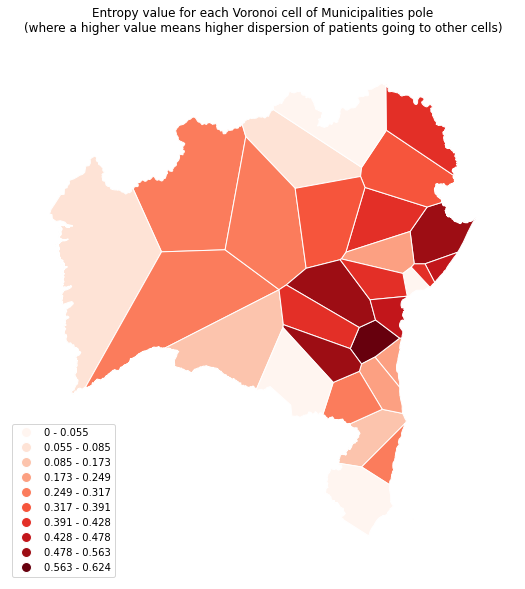

In [72]:
import geoplot
import mapclassify as mc

scheme = mc.FisherJenks(np.round(geo_voronoi['entropy'].astype('float64'), 3), k=10)

geoplot.choropleth(
    geo_voronoi, hue='entropy',
    edgecolor='white', linewidth=1,
    cmap='Reds', figsize=(12, 10),
    legend=True, scheme=scheme
)
plt.title('Entropy value for each Voronoi cell of Municipalities pole\n(where a higher value means higher dispersion of patients going to other cells)')
plt.show()

In [75]:
# poles_entropy2 = np.c_[poles.T[1], entropy(new_OD_matrix, axis=0)]
# geo_voronoi2 = gpd.GeoDataFrame({'geometry': voronoi_shapes, 'entropy': poles_entropy2.T[1]})
# scheme2 = mc.FisherJenks(np.round(geo_voronoi2['entropy'].astype('float64'), 3), k=10)

# geoplot.choropleth(
#     geo_voronoi2, hue='entropy',
#     edgecolor='white', linewidth=1,
#     cmap='Blues', figsize=(12, 10),
#     legend=True, scheme=scheme2
# )
# plt.title('Entropy value for each Voronoi cell of Municipalities pole\n(where a higher value means higher dispersion of patients from other cells)')
# plt.show()